In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore')

In [2]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score

def eval_model(y_true,y_predicted):
    cm = confusion_matrix(y_true, y_predicted) 
    cm_display=ConfusionMatrixDisplay(confusion_matrix = cm)
    cm_display.plot()
    print('accuracy score',accuracy_score(y_true, y_predicted))
    print(classification_report(y_true,y_predicted))

In [3]:
data=pd.read_csv('datasets/pokemon.csv')
data

,Name,Type1,Type2
0,bulbasaur,Grass,Poison
1,ivysaur,Grass,Poison
2,venusaur,Grass,Poison
3,charmander,Fire,NaN
4,charmeleon,Fire,NaN
...,...,...,...
804,stakataka,Rock,Steel
805,blacephalon,Fire,Ghost
806,zeraora,Electric,NaN
807,meltan,Steel,NaN


In [4]:
data.value_counts('Type1')

Type1
Water       114
Normal      105
Grass        78
Bug          72
Fire         53
Psychic      53
Rock         46
Electric     40
Poison       34
Ground       32
Fighting     29
Dark         29
Ghost        27
Dragon       27
Steel        26
Ice          23
Fairy        18
Flying        3
dtype: int64

In [5]:
data=data[data.Type1.isin(['Water','Grass','Fire'])][['Name','Type1']]
data

,Name,Type1
0,bulbasaur,Grass
1,ivysaur,Grass
2,venusaur,Grass
3,charmander,Fire
4,charmeleon,Fire
...,...,...
778,bruxish,Water
786,tapu-bulu,Grass
787,tapu-fini,Water
797,kartana,Grass


In [6]:
print('Data shape',data.shape)
print('Number of unique names',data.Name.nunique())

Data shape (245, 2)
Number of unique names 245


In [7]:
import os
import pandas as pd
import cv2

image_df = pd.DataFrame({'Name':[],'img':[]})


path_start='datasets/images'
for filename in os.listdir(path_start):
    if filename.endswith(".png"):
        image_name = filename.split('.')[0]  
        
        image = cv2.imread(os.path.join(path_start, filename))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
        image_df=image_df.append({'Name':image_name,'img':np.array(image)},ignore_index=True)
        
        
        
        
        
        

In [8]:
data=data.merge(image_df,how='inner', on='Name')

In [9]:
data.img.info()

<class 'pandas.core.series.Series'>
Int64Index: 218 entries, 0 to 217
Series name: img
Non-Null Count  Dtype 
--------------  ----- 
218 non-null    object
dtypes: object(1)
memory usage: 3.4+ KB


In [10]:
data.value_counts('Type1')

Type1
Water    105
Grass     66
Fire      47
dtype: int64

In [11]:
data.loc[0].img.shape

(120, 120, 3)

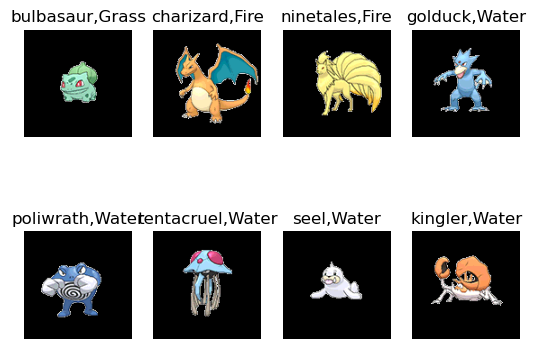

In [12]:
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.imshow(data.loc[i*5].img)
    plt.title(f"{data.loc[i*5].Name},{data.loc[i*5].Type1}")
    plt.axis('off')
plt.show()

In [13]:

X=np.array(data['img'].tolist(), dtype = np.float32)/255.0
y=data['Type1']

In [14]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

datagen = ImageDataGenerator(
        rotation_range=15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)


augmented_images = []
augmented_labels = []


for i in range(len(X)):
    image = X[i]
    label = y[i]
    image = np.expand_dims(image, axis=0)
    label = np.array([label])
    augmented_images_batch, augmented_labels_batch = [], []
    j=0
    for x_batch, y_batch in datagen.flow(image, label, batch_size=4):
        augmented_images_batch.extend(x_batch)
        augmented_labels_batch.extend(y_batch)
        j+=1
        if j>3:
            break
    augmented_images.extend(augmented_images_batch)
    augmented_labels.extend(augmented_labels_batch)

augmented_images = np.array(augmented_images)
augmented_labels = np.array(augmented_labels)

In [15]:
print(X.shape)
print(augmented_images.shape)

(218, 120, 120, 3)
(872, 120, 120, 3)


In [16]:
X=np.concatenate((X, augmented_images), axis=0)
y=np.concatenate((y,augmented_labels), axis=0)
print(X.shape)

(1090, 120, 120, 3)


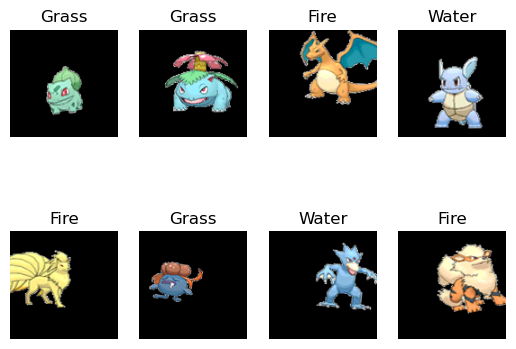

In [17]:
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.imshow(augmented_images[i*10])
    plt.title(f"{augmented_labels[i*10]}")
    plt.axis('off')
plt.show()

In [18]:
from sklearn.model_selection import train_test_split

labels_dict={'Water': 0, 'Grass': 1, 'Fire': 2}

y_final = []
for yi in y:
    y_final.append(labels_dict[yi])

X_train, X_test, y_train, y_test=train_test_split(X,y_final, test_size=.2)

X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)


In [19]:
cnn = models.Sequential([
    layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(120, 120, 3),kernel_regularizer=tf.keras.regularizers.l2(l=0.01)),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    
    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l=0.01)),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    
    layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l=0.01)),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(3, activation='softmax')
])

In [20]:
cnn.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 118, 118, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 59, 59, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 59, 59, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 57, 57, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 28, 28, 64)        0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 28, 28, 64)        0

In [21]:
histor=cnn.fit(X_train, y_train, epochs=20, validation_split=.2)

Epoch 1/20
22/22 [==============================] - 6s 261ms/step - loss: 2.1630 - accuracy: 0.3960 - val_loss: 1.8034 - val_accuracy: 0.4514
Epoch 2/20
22/22 [==============================] - 5s 244ms/step - loss: 1.5116 - accuracy: 0.5438 - val_loss: 1.3535 - val_accuracy: 0.5143
Epoch 3/20
22/22 [==============================] - 5s 241ms/step - loss: 1.1180 - accuracy: 0.6313 - val_loss: 1.0493 - val_accuracy: 0.6114
Epoch 4/20
22/22 [==============================] - 5s 246ms/step - loss: 0.9706 - accuracy: 0.6743 - val_loss: 0.9529 - val_accuracy: 0.6229
Epoch 5/20
22/22 [==============================] - 5s 243ms/step - loss: 0.7869 - accuracy: 0.7159 - val_loss: 0.8194 - val_accuracy: 0.7257
Epoch 6/20
22/22 [==============================] - 5s 244ms/step - loss: 0.6927 - accuracy: 0.7819 - val_loss: 0.8225 - val_accuracy: 0.6914
Epoch 7/20
22/22 [==============================] - 5s 243ms/step - loss: 0.6233 - accuracy: 0.7948 - val_loss: 0.6871 - val_accuracy: 0.7771
Epoch 

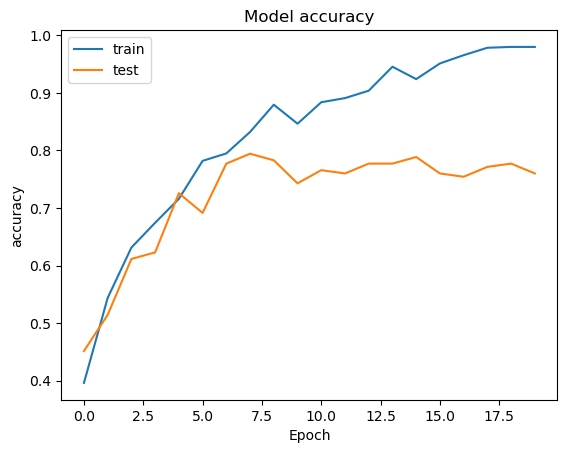

In [22]:
plt.plot(histor.history['accuracy'])
plt.plot(histor.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'test'])

In [23]:
y_pred=np.argmax(cnn.predict(X_test),axis=1)

7/7 [==============================] - 0s 54ms/step


7/7 [==============================] - 0s 56ms/step
accuracy score 0.7385321100917431
              precision    recall  f1-score   support

           0       0.73      0.79      0.76        99
           1       0.75      0.67      0.71        78
           2       0.74      0.76      0.75        41

    accuracy                           0.74       218
   macro avg       0.74      0.74      0.74       218
weighted avg       0.74      0.74      0.74       218



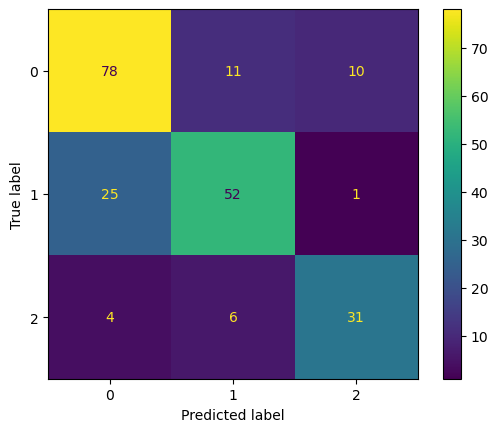

In [24]:
y_predicted=cnn.predict(X_test)
y_pred_labels = np.argmax(y_predicted, axis=1)
eval_model(y_test,y_pred_labels)